In [1]:
import warnings
import os

from functools import cached_property

import torch
from torchdiffeq import odeint
import torch.nn as nn

import numba

import numpy as np
from scipy.constants import pi, Boltzmann
from numpy.lib import recfunctions as rfn

import matplotlib.pyplot as plt

from cminject.utils.distributions import constant, GaussianDistribution, LinearDistribution, UniformDistribution

In [2]:
print(torch.cuda.is_available())
gpu = torch.device('cuda:0')

True


In [3]:
%matplotlib notebook

In [4]:
from abc import ABC, ABCMeta, abstractmethod

In [5]:
def get_properties_dict(cls):
    if hasattr(cls, 'Properties'):
        tgt = cls.Properties.__dict__
        parent_propss = [
            get_properties_dict(parent_cls)
            for parent_cls in cls.__bases__
        ]           
        own_props = {
            k: v for k, v in cls.Properties.__dict__.items()
            if not k.startswith('__')
        }

        result = {}
        for parent_props in parent_propss:
            result.update(parent_props)
        result.update(own_props)
        return result
    else:
        return {}

        
class ParticleEnsembleMetaclass(ABCMeta):
    def __new__(mcls, name, bases, dctn):
        cls = super().__new__(mcls, name, bases, dctn)        

        properties = get_properties_dict(cls)
        cls._props_dict = properties
        cls._props_names = list(properties.keys())
        cls._props_types = list(properties.values())
        cls._dtype_description = list(zip(cls._props_names, cls._props_types))
        cls._dtype = np.dtype(cls._dtype_description)

        return cls

    
class ParticlesBase(ABC, metaclass=ParticleEnsembleMetaclass):
    class Properties:
        pass
    
    def __repr__(self):
        clsname = self.__class__.__name__
        return f'<{clsname} ({self._n} particles)>'

    def __init__(self, n, distributions):
        for prop in self._props_names:
            if prop in distributions:
                setattr(self, prop, distributions[prop].generate(n))
            else:
                setattr(self, prop, np.empty(n))
                warnings.warn(
                    f'No distribution given for {prop}, it remains uninitialized (contains garbage data)!')
            
        self._n = n
        self._distributions = distributions
        
    def get_y0(self):
        if self._integrated is None or self._integrated == 'all':
            props = self._props_names
        else:
            props = self._integrated
        return tuple(getattr(self, prop) for prop in props)
        
    def to_torch(self, device=None):
        for name in self._props_names:
            tensor = torch.from_numpy(getattr(self, name))
            if device is not None:
                tensor = tensor.to(device)
            setattr(self, name, tensor)
        return self

In [6]:
class Particles(ParticlesBase):
    class Properties:
        id = np.int32
        lost = np.bool_
        time = np.float64
        
    def __init__(self, n, distributions, *args, **kwargs):
        if 'id' not in distributions:
            distributions['id'] = LinearDistribution(1, n)
        if 'lost' not in distributions:
            distributions['lost'] = constant(False)
        if 'time' not in distributions:
            distributions['time'] = constant(0)
            
        super().__init__(n, distributions, *args, **kwargs)
    

class SphericalParticles(Particles):
    class Properties:
        radius = np.float64
        rho = np.float64
        
    @property
    def mass(self):
        return 4/3 * self.radius**3 * np.pi * self.rho
    
    
class RZParticles(ParticlesBase):
    class Properties:
        r = np.float64
        z = np.float64
        vr = np.float64
        vz = np.float64
    

class XYZParticles(ParticlesBase):
    class Properties:
        x = np.float64
        y = np.float64
        z = np.float64
        vx = np.float64
        vy = np.float64
        vz = np.float64

In [7]:
class MyParticleEnsemble(SphericalParticles, RZParticles):
    _integrated = ('r', 'vr', 'z', 'vz')


ensemble = MyParticleEnsemble(1000, {
    'r': GaussianDistribution(0, 1e-3),
    'z': GaussianDistribution(0, 1e-1),
    'vr': GaussianDistribution(-1, 1),
    'vz': constant(50),
    
    'radius': GaussianDistribution(25e-6, 1e-6),
    'rho': constant(1050),
})
ensemble.to_torch()


class MySimulation(nn.Module):
    def forward(self, t, state):
        (r, vr, z, vz) = state
        const0 = torch.zeros_like(r)
        const1 = torch.ones_like(r)

        dz = vz
        dr = vr
        dvr = const0
        dvz = -1000 * const1 * torch.sin(t * 10 * np.pi)
            
        return (dr, dvr, dz, dvz)


t = torch.linspace(0, 0.5, 100)
r, vr, z, vz = odeint(MySimulation(), ensemble.get_y0(), t)

In [8]:
plt.figure()
plt.plot(t, z)
pass

<IPython.core.display.Javascript object>

# What about fluid flow forces?

## let's read in and plot some data...

In [9]:
from cminject.utils.structured_txt_hdf5 import hdf5_to_data_grid
grid, data = hdf5_to_data_grid('/home/chip/Documents/cminject-materials/goldspheres-27nm/nitrogen_1.8mbar_extended_nan.h5')

plt.close('all')
plt.figure()

Vr, Vz, P = data.T
Vr, Vz, P = Vr.reshape(-1), Vz.reshape(-1), P.reshape(-1)

ensemble = P

plt.plot(P, Vr, 'x', markersize=1, label='vr')
plt.plot(P, Vz, 'x', markersize=1, label='vz')
plt.xlabel('p')
plt.ylabel('v{r,z}')
plt.legend()

plt.figure()
plt.scatter(Vr, Vz, c=np.log(P), s=2)
plt.xlabel('vr')
plt.ylabel('vz')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0, 0.5, 'vz')

In [10]:
data.shape

(201, 1336, 3)

## Let's now define a torch-based bilinear interpolator:

In [11]:
class MyInterp2D(nn.Module):
    def __init__(self, grid, data):
        super().__init__()
        x, y = grid
        self.data = torch.from_numpy(data)

        self.nx, self.ny, self.nd = data.shape
        self.min_x, self.max_x = x[0], x[-1]
        self.min_y, self.max_y = y[0], y[-1]
        self.delta_x = (self.max_x - self.min_x) / (x.shape[0] - 1)
        self.delta_y = (self.max_y - self.min_y) / (y.shape[0] - 1)

    def forward(self, x, y):
        x0 = (x - self.min_x) / self.delta_x
        y0 = (y - self.min_y) / self.delta_y
        xi = x0.type(torch.int64)
        yi = y0.type(torch.int64)
        xweights = (x0 - xi.type(torch.float64)).reshape(-1, 1)
        yweights = (y0 - yi.type(torch.float64)).reshape(-1, 1)
        
        outofbounds = (xi < 0) + (xi >= self.nx-1) + (yi < 0) + (yi >= self.ny-1)
        xi = torch.where(outofbounds, 0, xi)  # FIXME for general case where top left corner is not NaN
        yi = torch.where(outofbounds, 0, yi)

        a0 = torch.lerp(self.data[xi, yi  ], self.data[xi+1, yi  ], xweights)
        a1 = torch.lerp(self.data[xi, yi+1], self.data[xi+1, yi+1], xweights)
        return torch.lerp(a0, a1, yweights)

### (Bilinear) Interpolation seems to work now :)

Even on the GPU :D

In [12]:
i2d = MyInterp2D(grid, data)
i2d.data = i2d.data.to(gpu)  # even on the GPU :D

In [13]:
M, N = 1000, 1000
x = torch.linspace(0, 1e-3, M).to(gpu)
y = torch.linspace(-1e-2, 1e-3, N).to(gpu)
y = torch.linspace(-1e-2, 1e-3, N).to(gpu)
X, Y = torch.meshgrid(x, y)
X = X.reshape(-1)
Y = Y.reshape(-1)

result = i2d(X, Y).reshape(M, N, -1).cpu()

plt.figure()
plt.imshow(result[...,0], aspect='auto', interpolation='nearest')

<IPython.core.display.Javascript object>

Let's try defining a fluid flow simulation (disregarding Brownian motion)...

In [14]:
def nan_to_zero(tensor):
    return torch.where(torch.isnan(tensor), 0.0, tensor)

In [15]:
class FluidSimulation(nn.Module):
    def __init__(self, ensemble):
        super().__init__()
        self._ensemble = ensemble
        
        self.T = 293.15
        self.mu = 1.76e-5
        self.m_f = 4.7e-26
        self.Kfac = np.sqrt(pi * Boltzmann * self.T / (2 * self.m_f))
    
    def forward(self, t, state):
        (r, vr, z, vz) = state

        vr_f, vz_f, p_f = i2d(r, z).T
        delta_vr = vr_f - vr
        delta_vz = vz_f - vz

        r_p = self._ensemble.radius
        knudsen = self.mu / (p_f * r_p) * self.Kfac
        cc = 1 + knudsen * (1.231 + 0.4695 * torch.exp(-1.1783 / knudsen))

        a0 = 6 * np.pi * self.mu * r_p / self._ensemble.mass / cc
        ar = a0 * delta_vr
        az = a0 * delta_vz

        vr = nan_to_zero(vr)
        ar = nan_to_zero(ar)
        vz = nan_to_zero(vz)
        az = nan_to_zero(az)
        return (vr, ar, vz, az)

In [16]:
i2d = MyInterp2D(grid, data)
i2d.data = i2d.data

ensemble_params = {
    'r': GaussianDistribution(0, 0.0002),
    'z': constant(-0.128),
    'vr': GaussianDistribution(0, 1),
    'vz': GaussianDistribution(1, 0.1),
    
    'radius': GaussianDistribution(1.35e-8, 1.91e-9),
    'rho': constant(19320),
}
t = torch.arange(0, 0.03, 1e-5)
t.shape

torch.Size([3000])

In [17]:
ensemble = MyParticleEnsemble(50000, ensemble_params)
ensemble.to_torch(gpu)
i2d = MyInterp2D(grid, data)
i2d.data = i2d.data.to(gpu)
t = t.to(gpu)

In [18]:
%%timeit -n1 -r1
with torch.no_grad():
    pass
    #result = odeint(FluidSimulation(ensemble), ensemble.get_y0(), t)
    #del result

11.2 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [19]:
torch.cuda.empty_cache()

<IPython.core.display.Javascript object>


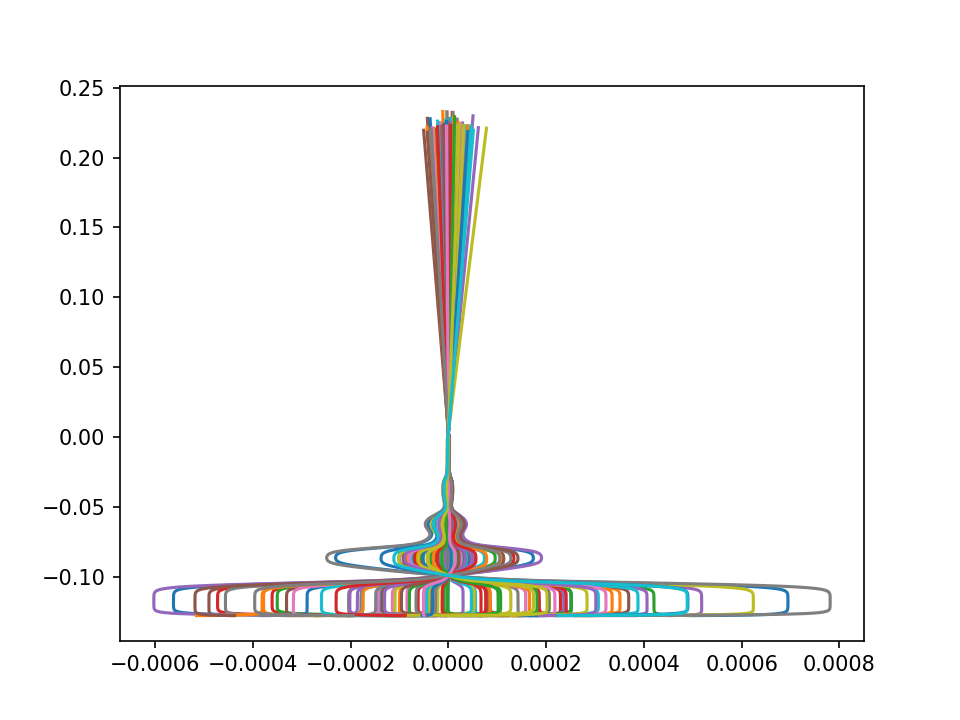

In [20]:
result = odeint(FluidSimulation(ensemble), ensemble.get_y0(), t)
(r, _, z, _) = result
r = r.cpu()
z = z.cpu()
del result
torch.cuda.empty_cache()

plt.close('all')
plt.figure()
plt.plot(r[:,:100].cpu(), z[:,:100].cpu())
pass

# On to SDEs...